<a href="https://colab.research.google.com/github/christianbaptista/dio-ml-ai-projects/blob/main/transferlearningnapratica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [6]:
!wget --no-check-certificate \
"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
-O "/tmp/cats-and-dogs.zip"


--2024-12-11 12:33:10--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.63.157.23, 2600:1408:c400:387::317f, 2600:1408:c400:38b::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.63.157.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   227MB/s    in 3.5s    

2024-12-11 12:33:14 (223 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [7]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [8]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [9]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
  pass

In [10]:
!ls /tmp/cats-v-dogs/

testing  training


In [11]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [12]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [15]:

# Note that this may take some time.
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 5/90 ━━━━━━━━━━━━━━━━━━━━ 9:42 7s/step - acc: 0.5032 - loss: 2.2473

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 602s 7s/step - acc: 0.5345 - loss: 0.9822 - val_acc: 0.5240 - val_loss: 0.6811
Epoch 2/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5280 - val_loss: 0.6780
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 603s 7s/step - acc: 0.6145 - loss: 0.6618 - val_acc: 0.6860 - val_loss: 0.5892
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6860 - val_loss: 0.6023
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 614s 7s/step - acc: 0.6844 - loss: 0.5895 - val_acc: 0.5473 - val_loss: 0.6585
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5560 - val_loss: 0.6578
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 599s 7s/step - acc: 0.7140 - loss: 0.5463 - val_acc: 0.7480 - val_loss: 0.5124
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.7370 - val_loss: 0.5225
Epoch 9/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 605s 7s/step - acc: 0.7409 - loss: 0.5121 - val_acc: 0.7353 - val_loss: 0.5277
Epoch 10/15
90/90 ━━━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

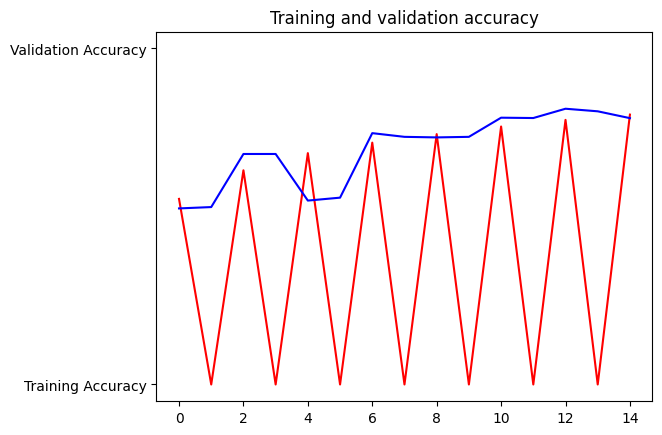

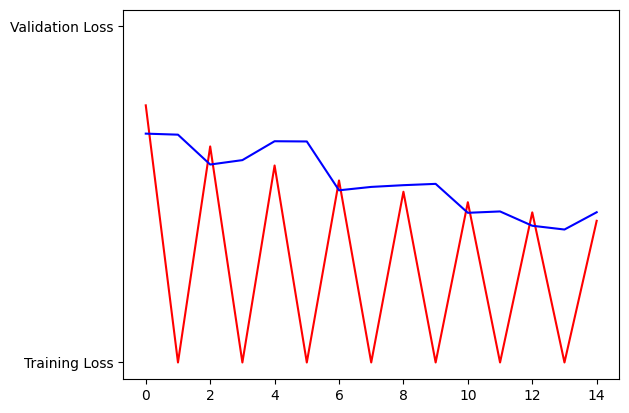

<Figure size 640x480 with 0 Axes>

In [16]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [18]:
!mkdir /content
!cd /content/
!wget https://inovaveterinaria.com.br/wp-content/uploads/2015/04/gato-sem-raca-INOVA-1024x683.jpg

mkdir: cannot create directory ‘/content’: File exists
--2024-12-11 14:01:40--  https://inovaveterinaria.com.br/wp-content/uploads/2015/04/gato-sem-raca-INOVA-1024x683.jpg
Resolving inovaveterinaria.com.br (inovaveterinaria.com.br)... 170.82.174.30, 170.82.173.30
Connecting to inovaveterinaria.com.br (inovaveterinaria.com.br)|170.82.174.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114154 (111K) [image/jpeg]
Saving to: ‘gato-sem-raca-INOVA-1024x683.jpg’

gato-sem-raca-INOVA 100%[===================>] 111.48K  --.-KB/s    in 0.05s   

2024-12-11 14:01:41 (2.18 MB/s) - ‘gato-sem-raca-INOVA-1024x683.jpg’ saved [114154/114154]



In [21]:
# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")


Saving cao_foto-abre1.webp to cao_foto-abre1.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[1.]
cao_foto-abre1.webp is a dog
